# *Graph-Sparse* Logistic Regression for sparse recovery of the dysregulated pathways in our synthetic datasets

In [1]:
%pylab inline
# %load_ext line_profiler

import sys
import pickle
from timeit import default_timer as timer

import pandas as pd

from sklearn.preprocessing import LabelEncoder

from matplotlib_venn import venn3, venn3_circles, venn2

repo_path = '/Users/alex/Documents/proteomics/'
data_path = '/Users/alex/Documents/proteomics/synthetic_proteomics/generated_data/ludwig_svd_normals/'

# repo_path = '/Users/ludwig/research/model_cs/cluster_model/bio/repo2/'
# data_path = '/Users/ludwig/research/model_cs/cluster_model/bio/data/'

sys.path.append(repo_path + 'synthetic_proteomics/analysis/gslr/')
import gslr

Populating the interactive namespace from numpy and matplotlib


### I. Load Synthetic Dataset which is known to be at least somewhat connected in the interactome. 

In [2]:
dataset = pd.read_csv(data_path + 'hsa04110_inbiomap_exp.csv', index_col=0)
dataset.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa04110,0.0,0.014856,0.264810,0.109797,-0.976005,0.173769,0.0,0.285756,0.288839,-0.231566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.228736,0.089442,0.339065,-0.597546,0.040049,0.0,-0.098450,0.073976,-0.494193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.715740,-0.143526,-0.480106,0.125846,0.284645,-0.0,0.021132,-0.115910,-0.016950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.383979,0.359009,0.394243,-0.387827,-0.281805,0.0,-0.922308,0.340674,-0.278771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.023037,0.196800,-0.292508,0.165186,0.105207,0.0,-0.521385,-0.194466,-0.234121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### II. Extract Labels

In [3]:
labeler = LabelEncoder()
labeler.fit(dataset.index.tolist())
labels = labeler.transform(dataset.index.tolist())
y = labels
y

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])

### III. Load Interactome

In [4]:
inbiomap_experimentally = pd.read_csv('../pcsf/inbiomap_temp.tsv', sep='\t', names=['protein1','protein2','cost'])
inbiomap_experimentally.head()

,protein1,protein2,cost
0,ZNF91,NDEL1,1.253
1,ZNF91,ELAVL1,1.254
2,ZNF91,SUMO1,1.245
3,ZNF91,SUMO3,1.245
4,ZNF91,CHMP5,1.241


In [5]:
(edges, nodes) = pd.factorize(inbiomap_experimentally[["protein1","protein2"]].unstack())
edges = edges.reshape(inbiomap_experimentally[["protein1","protein2"]].shape, order='F')
edges

array([[    0,  1228],
       [    0,  1279],
       [    0,  4071],
       ..., 
       [14190, 14237],
       [14191, 14378],
       [14192, 14539]])

In [6]:
dataset.columns

Index(['ZNF91', 'NDEL1', 'ELAVL1', 'SUMO1', 'SUMO3', 'CHMP5', 'UBC', 'HTT',
       'E2F4', 'ACP5',
       ...
       'SPANXN4', 'ZNF605', 'SERPINB10', 'ANKAR', 'RRH', 'DHH', 'CYSLTR1',
       'ZNF268', 'COL23A1', 'MEDAG'],
      dtype='object', length=16349)

In [7]:
nodes

Index(['ZNF91', 'ACP5', 'SLC27A2', 'PAX9', 'ADAM15', 'ELOVL2', 'DDX60L',
       'FGF7', 'CDHR5', 'LYPD3',
       ...
       'CNR2', 'GIG44', 'LINC00588', 'TAAR2', 'CHRNE', 'ANKAR', 'DHH',
       'CYSLTR1', 'COL23A1', 'MEDAG'],
      dtype='object', length=16349)

### IV. Prepare Dataset

In [8]:
dataset = dataset.transpose().reindex(index=nodes).transpose()
X = dataset.values
dataset.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
hsa04110,0.0,-0.231566,-0.194981,-0.0,0.251072,-0.0,0.570449,0.0,-0.0,-0.692269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.494193,0.026474,0.0,0.281624,-0.0,0.521439,-0.0,-0.0,-0.799044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.016950,0.181384,0.0,0.546825,-0.0,-0.090188,0.0,-0.0,0.234445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.278771,-0.403404,-0.0,0.168978,-0.0,-1.855316,0.0,-0.0,-0.800104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.234121,0.114927,0.0,0.295396,-0.0,-1.144877,0.0,-0.0,0.910444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### V. Graph-Sparse Logistic Regression

In [9]:
d = len(nodes)
c = 2

graph_opts = gslr.GraphOptions(edges=edges, root=-1, num_clusters=1, pruning='strong')

sparsity_low = 80
sparsity_high = 160

verbosity_level = 1

num_steps = 25
possible_steps = np.array([0.03, 0.1, 0.3])
steps = np.tile(possible_steps, (num_steps, 1))

W0 = np.zeros((c, d))

In [43]:
W_hat, losses = gslr.gslr(X, y, W0, sparsity_low, sparsity_high, graph_opts, steps, verbosity_level, edge_costs=inbiomap_experimentally.cost.values, edge_costs_multiplier=6)

iteration 1:
  loss_cur = 0.6931471805599465   loss_next = 0.6537647267268138   step_size = 0.03
  loss_cur = 0.6931471805599465   loss_next = 0.5797527894830647   step_size = 0.1
  loss_cur = 0.6931471805599465   loss_next = 0.4759224281608484   step_size = 0.3
  best_step_size: 0.3
iteration 2:
  loss_cur = 0.4759224281608484   loss_next = 0.46149257220740947   step_size = 0.03
  loss_cur = 0.4759224281608484   loss_next = 0.4262615639353607   step_size = 0.1
  loss_cur = 0.4759224281608484   loss_next = 0.5275621497808476   step_size = 0.3
  best_step_size: 0.1
iteration 3:
  loss_cur = 0.4262615639353607   loss_next = 0.4192312491146555   step_size = 0.03
  loss_cur = 0.4262615639353607   loss_next = 0.4030827802080785   step_size = 0.1
  loss_cur = 0.4262615639353607   loss_next = 0.6020540438495441   step_size = 0.3
  best_step_size: 0.1
iteration 4:
  loss_cur = 0.4030827802080785   loss_next = 0.3974760419269741   step_size = 0.03
  loss_cur = 0.4030827802080785   loss_next = 0

Train accuracy: 0.985


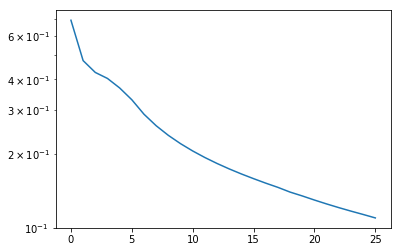

In [44]:
yhat = gslr.predict(X, W_hat)
num_cor = gslr.num_correct(y, yhat)
print('Train accuracy: {}'.format(num_cor / float(len(y))))

plt.plot(losses)
plt.yscale('log')

### VI. Examine Results

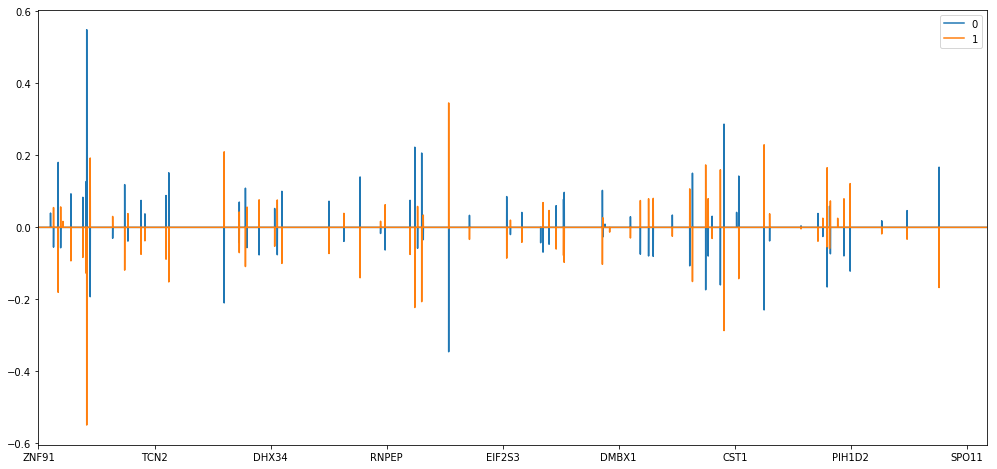

In [45]:
coefs = pd.DataFrame(W_hat, columns=dataset.columns)
coefs.transpose().plot(figsize=(17,8))

In [51]:
features = coefs.columns[(coefs != 0).any()].tolist()
len(features)

82

/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


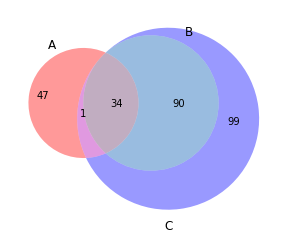

In [47]:
pathways_df = pd.read_pickle('../../data_generation/KEGG_df.filtered.with_correlates.pickle')
genes, correlates = pathways_df.loc[pd.IndexSlice[:, :, ['hsa04110']],['genes', 'correlates']].values[0]
correlates = correlates.tolist()
venn3([set(features), set(genes), set(genes)|set(correlates)])

### V. Analysis of edge weights in kegg pathways versus solutions given by GSLR

In [48]:
import pandas as pd
import networkx as nx

interactome_file = "/Users/alex/Documents/proteomics/data_preparation/interactomes/InBioMap/inbiomap_exp.normalized.cleaned.connected.tsv"

interactome_dataframe = pd.read_csv(interactome_file, sep='\t')

interactome_graph = nx.from_pandas_dataframe(interactome_dataframe, 'protein1', 'protein2', edge_attr=['confidence'])

### Selected subgraph edge confidences histogram

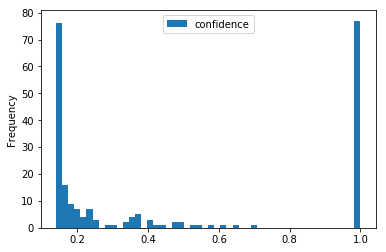

In [49]:
subgraph = interactome_graph.subgraph(features)
confidences = pd.DataFrame([confidence_dict['confidence'] for source, target, confidence_dict in subgraph.edges(data=True)], columns=['confidence']).astype(float)
confidences.plot.hist(bins=50)

### Ground Truth subgraph edge confidence histogram

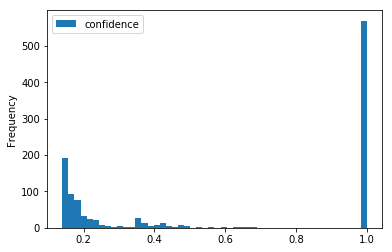

In [50]:
subgraph2 = interactome_graph.subgraph(genes)
confidences2 = pd.DataFrame([confidence_dict['confidence'] for source, target, confidence_dict in subgraph2.edges(data=True)], columns=['confidence']).astype(float)
confidences2.plot.hist(bins=50)